# **Análisis Exploratorio de los Datos**
---

A continuación cargaremos la base de datos ASL_ALPHABET. Esta contiene datos de imágenes de señas del Lenguaje de Señas del Alfabeto Inglés, para 29 clases, 26 de ellas para las letras de la A a la Z, y 3 adiconales para el caracter 'del' o eliminar, 'space' o espacio, 'nothing' para una imagen sin señas.


In [2]:
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import os
import kagglehub
from PIL import Image
import seaborn as sns

In [3]:

root_path = "/content/mlds6/data/raw/asl-alphabet/"

datos = []

# ---------------------------
# Procesar TRAIN (carpetas)
# ---------------------------
train_path = os.path.join(root_path, "asl_alphabet_train/asl_alphabet_train")

clases_train = [d for d in os.listdir(train_path)
                if os.path.isdir(os.path.join(train_path, d))]

for clase in clases_train:
    ruta_clase = os.path.join(train_path, clase)

    for img in os.listdir(ruta_clase):
        if img.lower().endswith((".jpg", ".png", ".jpeg")):
            datos.append({
                "ruta_archivo": os.path.join(ruta_clase, img),
                "conjunto": "train",
                "etiqueta": clase
            })

# ---------------------------
# Procesar TEST (un archivo por clase)
# ---------------------------
test_path = os.path.join(root_path, "asl_alphabet_test/asl_alphabet_test")

for img in os.listdir(test_path):
    if img.lower().endswith((".jpg", ".png", ".jpeg")):

        # ejemplo: A_test.jpg → label = A
        label = img.split("_")[0]

        datos.append({
            "ruta_archivo": os.path.join(test_path, img),
            "conjunto": "test",
            "etiqueta": label
        })

# ---------------------------
# Crear DataFrame
# ---------------------------
df = pd.DataFrame(datos)

df.head()


ruta_archivo conjunto etiqueta
0  /content/mlds6/data/raw/asl-alphabet/asl_alpha...    train        R
1  /content/mlds6/data/raw/asl-alphabet/asl_alpha...    train        R
2  /content/mlds6/data/raw/asl-alphabet/asl_alpha...    train        R
3  /content/mlds6/data/raw/asl-alphabet/asl_alpha...    train        R
4  /content/mlds6/data/raw/asl-alphabet/asl_alpha...    train        R

### **Resumen General**

In [4]:
num_files = df["ruta_archivo"].unique().shape[0]
format = df["ruta_archivo"].str.split(".").str[1].unique()[0]
clases = df["etiqueta"].unique()

def get_folder_size(folder_path):
    """Size of a folder in MB"""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.exists(fp) and not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size / (1024*1024)

dataset_size = get_folder_size("/content/mlds6/data/raw/asl-alphabet/")


text = f"""
El dataset cuenta con un total de {num_files} documentos, correspondientes a imagenes en formato {format}
Las imagenes estan clasificadas en las etiquetas {clases}
El conjunto de imagenes pesa un total de {dataset_size:.2f} MB
"""

print(text)


El dataset cuenta con un total de 87028 documentos, correspondientes a imagenes en formato jpg
Las imagenes estan clasificadas en las etiquetas ['R' 'V' 'D' 'C' 'M' 'U' 'E' 'G' 'del' 'S' 'B' 'W' 'F' 'nothing' 'H' 'Q'
 'J' 'A' 'L' 'Y' 'space' 'N' 'K' 'P' 'T' 'Z' 'X' 'I' 'O']
El conjunto de imagenes pesa un total de 1055.21 MB



### **1.2. Resumen de la Calidad de los datos**
---

- ¿Hay datos faltantes, documentos vacíos o de mala calidad?
- ¿Existen documentos ilegibles o con problemas de codificación?
- ¿Hay mezcla de formatos en el conjunto?

In [41]:
readable_image = 0
broken_image = 0
img_size = []
for img_path in df["ruta_archivo"]:
    try:
        img = Image.open(img_path)
        readable_image += 1
        img_size.append(img.size)
    except Exception as e:
        print(f"Error al abrir la imagen {img_path}: {e}")
        broken_image += 1

print(f"Imagenes legible: {readable_image}")
print(f"Imagenes con problemas: {broken_image}")

Imagenes legible: 87028
Imagenes con problemas: 0


In [44]:
display(df['etiqueta'].info())
print(clases)

<class 'pandas.core.series.Series'>
RangeIndex: 87028 entries, 0 to 87027
Series name: etiqueta
Non-Null Count  Dtype 
--------------  ----- 
87028 non-null  object
dtypes: object(1)
memory usage: 680.0+ KB


None

['R' 'V' 'D' 'C' 'M' 'U' 'E' 'G' 'del' 'S' 'B' 'W' 'F' 'nothing' 'H' 'Q'
 'J' 'A' 'L' 'Y' 'space' 'N' 'K' 'P' 'T' 'Z' 'X' 'I' 'O']


Todos los documentos pueden ser leidos como imagen, ademas en las etiquetas no se tienen valores nulos o faltantes, siempre estan en las categorias **A-Z**, **del**, **space** o **nothing**

In [45]:
img_size_str = pd.DataFrame([str(size) for size in img_size])
size_df = pd.concat(
    [
        img_size_str.value_counts(),
        100*img_size_str.value_counts()/img_size_str.shape[0]
    ],
    axis=1
).reset_index()

size_df.columns = ["tamaño", "frecuencia", "porcentaje"]
size_df

tamaño  frecuencia  porcentaje
0  (200, 200)       87028       100.0

Todas las imagenes tienen un tamaño de 200x200 pixeles

### **Revisión de valores atípicos**

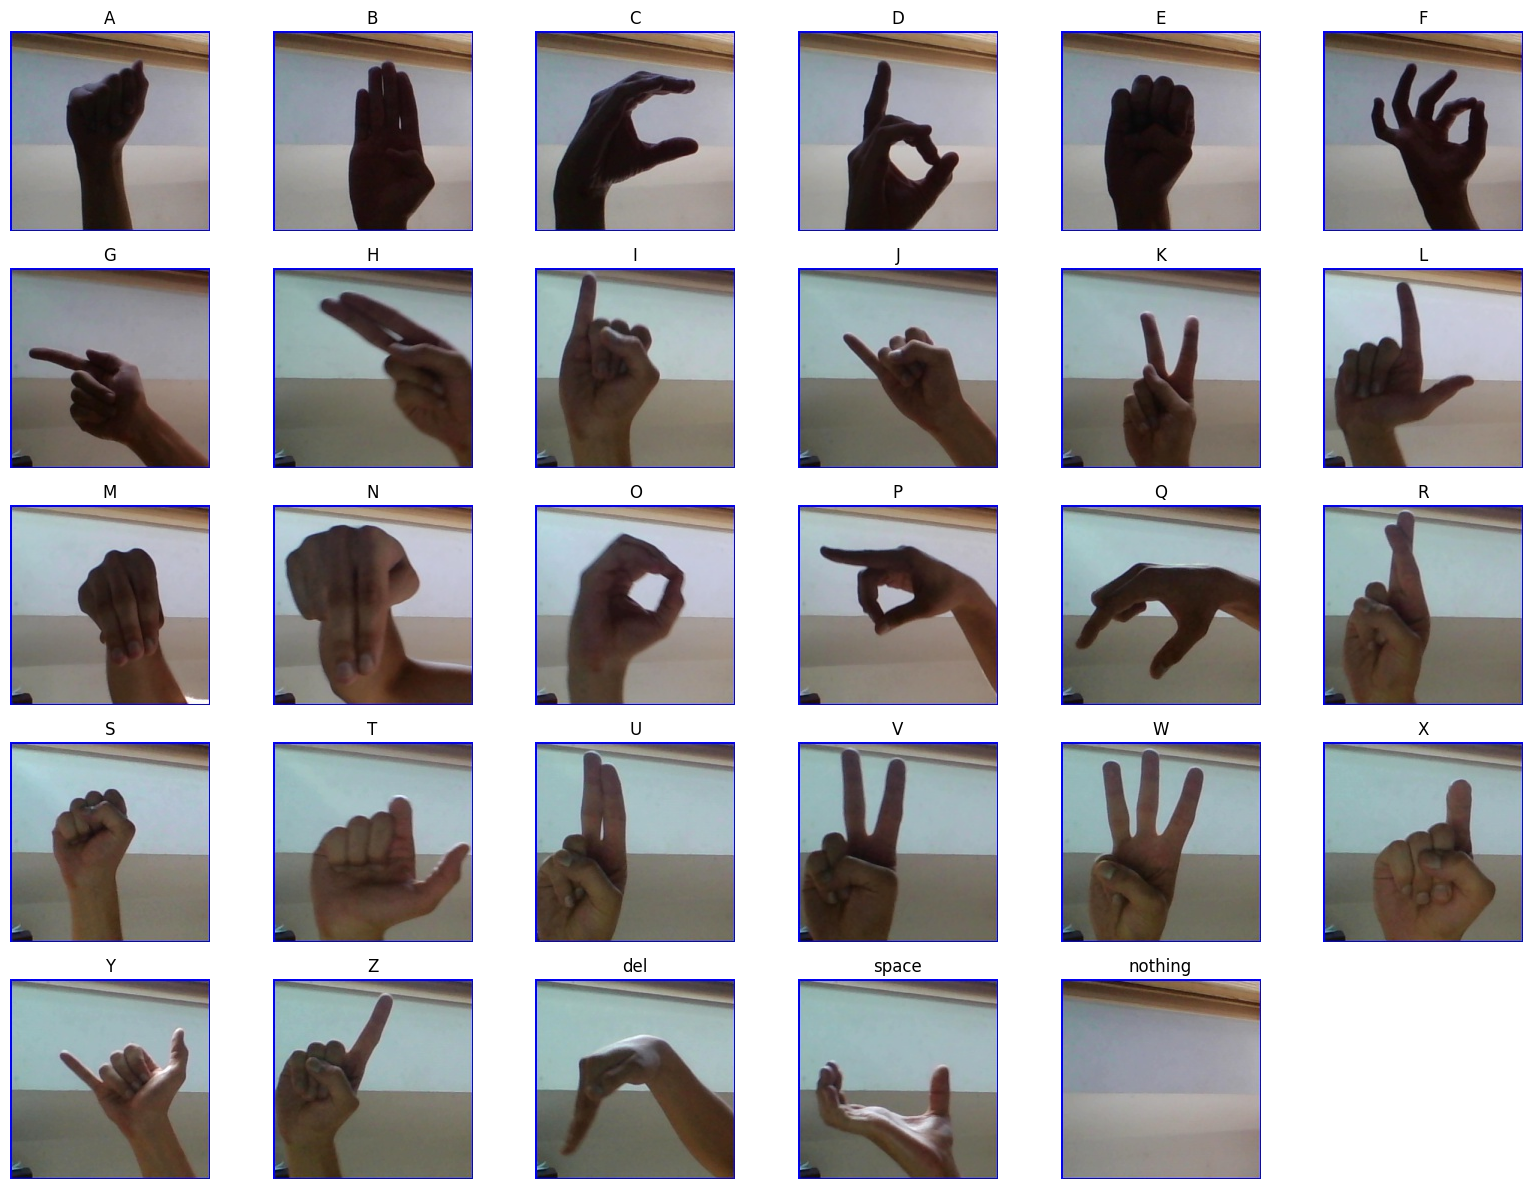

In [54]:

# Ruta del dataset (solo TRAIN)
train_dir = "/content/mlds6/data/raw/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

# Lista de clases
classes = [chr(i) for i in range(ord("A"), ord("Z")+1)] + ["del", "space", "nothing"]

# Obtener una imagen por clase desde TRAIN
image_paths = {}
for label in classes:
    class_folder = os.path.join(train_dir, label)

    # Buscar solo si existe la carpeta
    if os.path.isdir(class_folder):
        files = sorted(os.listdir(class_folder))
        # Buscar la primera imagen válida
        for f in files:
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                image_paths[label] = os.path.join(class_folder, f)
                break

# Mostrar todas las imágenes
plt.figure(figsize=(16,12))
for i, label in enumerate(classes):
    img = Image.open(image_paths[label])

    plt.subplot(5, 6, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

Despues de realizar una inspección visual de las imágenes, es posible ver que el fondo de todas las imagenes es igual, todas las fotos contienen la mano de una persona blanca, no usa manillas o algun otro accesorio, ni se envidencia la manga de alguna camisa.

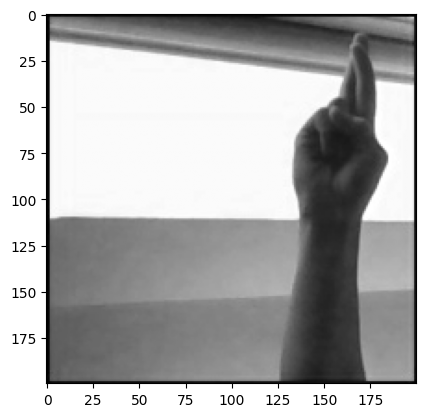

In [57]:
def read_image_gray_scale(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    return img_array[:,:,0]/255

img_array_test = read_image_gray_scale(df["ruta_archivo"][0])
plt.imshow(img_array_test, cmap='gray')

In [59]:
df["mean_pixel_value"] = df["ruta_archivo"].apply(lambda x: np.mean(read_image_gray_scale(x)))
df["std_pixel_value"] = df["ruta_archivo"].apply(lambda x: np.std(read_image_gray_scale(x)))

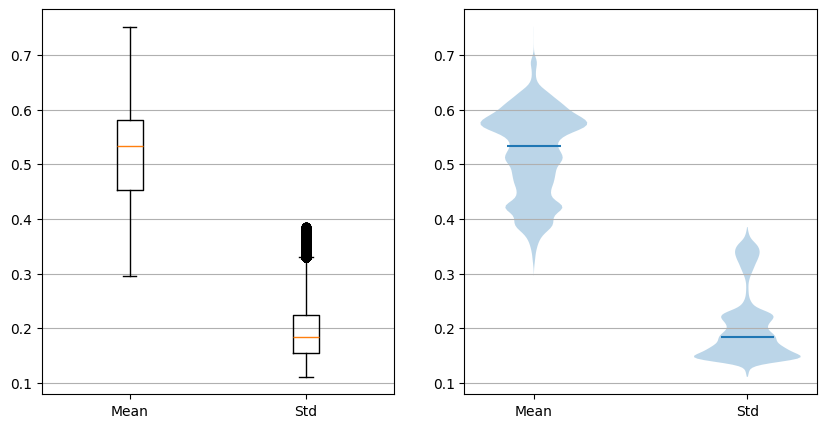

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.boxplot([df["mean_pixel_value"], df["std_pixel_value"]], tick_labels=["Mean", "Std"])
ax1.yaxis.grid(True)
ax2.violinplot([df["mean_pixel_value"], df["std_pixel_value"]], showextrema=False, showmedians=True)
ax2.set_xticks([1,2], labels=["Mean", "Std"])
ax2.yaxis.grid(True)

fig.show()

Se ponen las imagenes en escala de grises para revisar la distribución de color de las imágenes, y se evidencia que no hay valores atípicos en el promedio de los pixeles de las imagenes, esto puede explicarse dado que todas las imagenes parecen ser tomadas por la misma camara en el mismo cuarto.

Sin embargo, si existen valores atípicos asociados a la desviación estandar.

Outliers de la desviación estandar detectados: 8087


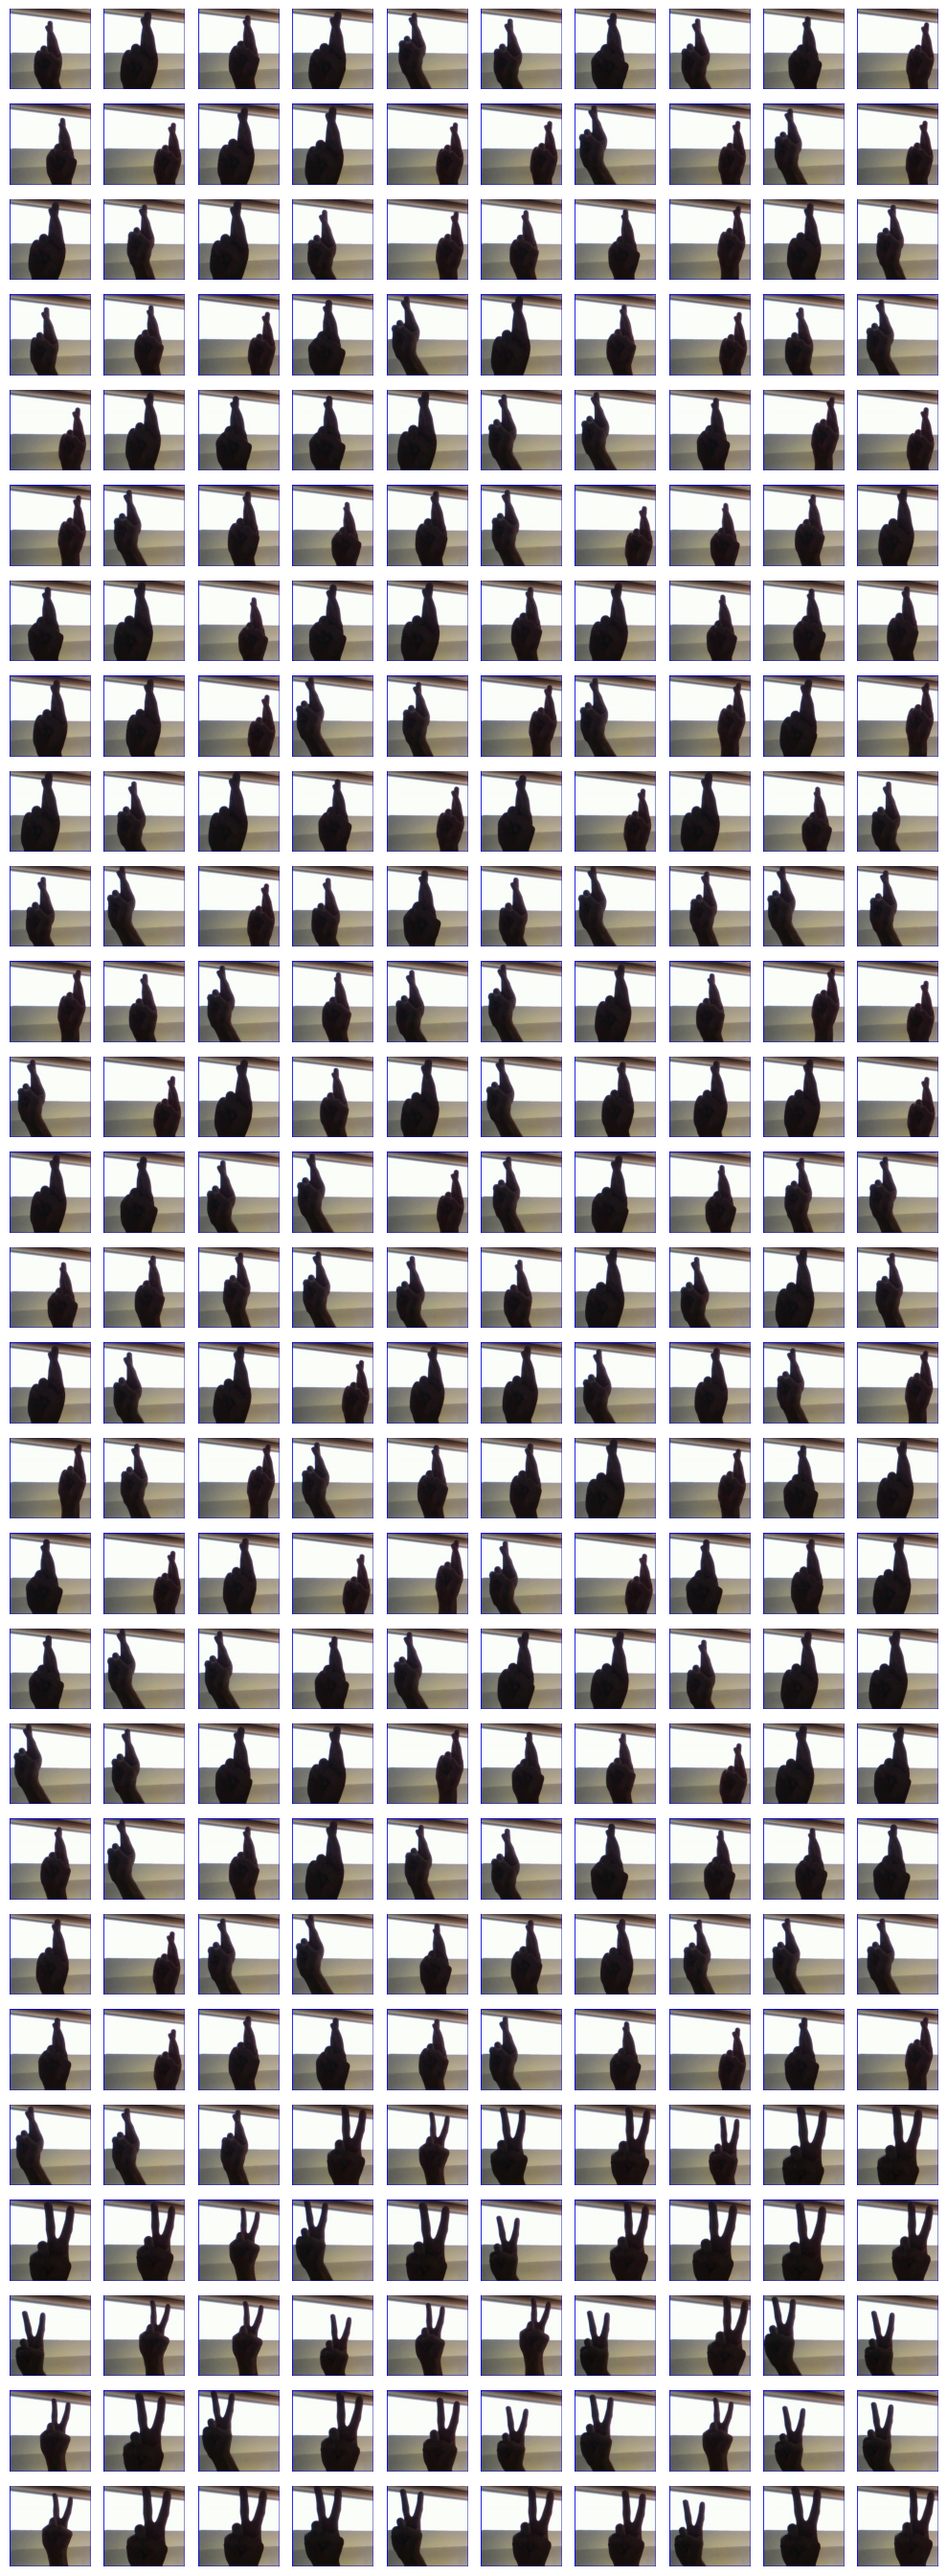

In [65]:
df_std_outliers = df[df["std_pixel_value_outlier"]==True].reset_index(drop=True)
print("Outliers de la desviación estandar detectados:", df_std_outliers.shape[0])

fig, axes = plt.subplots(27, 10, figsize=(10,27))

axes = axes.flatten()
for i, ax in enumerate(axes):
    if i >= len(df_std_outliers):
        ax.axis("off")
        continue
    img = Image.open(df_std_outliers["ruta_archivo"][i])
    ax.imshow(img) #, cmap='gray')
    ax.axis("off")

plt.tight_layout()
plt.show()

Al hacer una inspección visual de las fotos con un valor atípico en la desviación estadar, que no se trata de imagenes dañadas, si no que por el contrario, se evidencia que son imagenes donde la mano se ve oscura, lo que genera un alto contraste con el fondo. no se ve problema en este tipo de imagenes, de hecho es posible que ayuden a generalizar los resultados del modelo.

### **Revisión balance de clases**

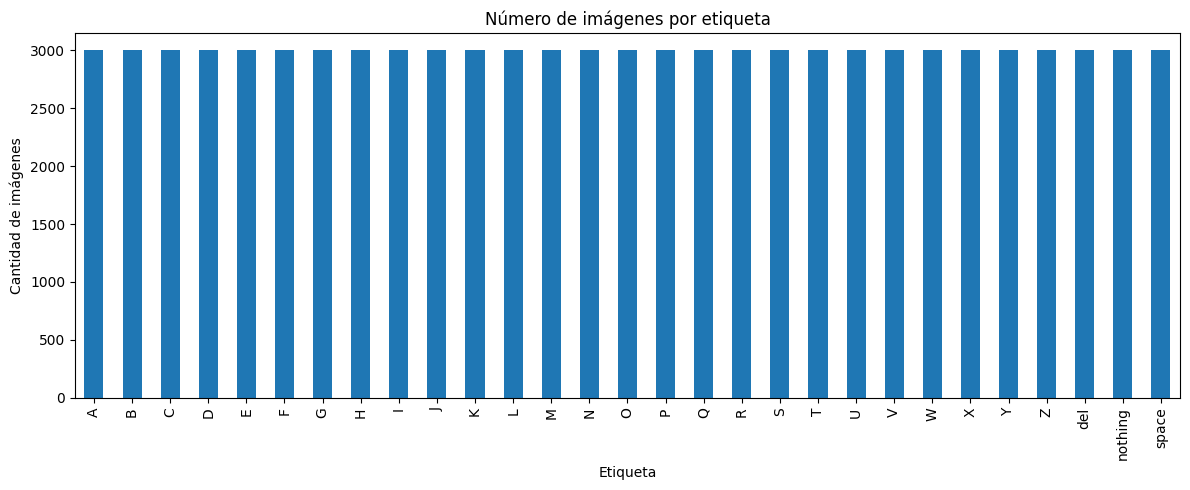

In [49]:
import matplotlib.pyplot as plt

counts = df["etiqueta"].value_counts().sort_index()

plt.figure(figsize=(12,5))
counts.plot(kind="bar")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad de imágenes")
plt.title("Número de imágenes por etiqueta")
plt.tight_layout()
plt.show()

In [ ]:
Revisando el balance de las clases se ve que estan perfectamente balanceadas.